# Fine tuning Google's FLAN T5 for financial news sentiment analysis
# using LoRa technic

### www.soligale.com
### https://www.youtube.com/watch?v=3NWfzSS2PTM

In [ ]:
from transformers import (
    T5ForConditionalGeneration,
    AutoTokenizer,
    TrainingArguments,
    Trainer
)
from peft import (
    PeftModel,
    TaskType,
    LoraConfig,
    get_peft_model,
)
import datasets

In [2]:
model_name = "./saved_models/Base"

In [3]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)
print_trainable_parameters(model)

trainable params: 247577856 || all params: 247577856 || trainable%: 100.00


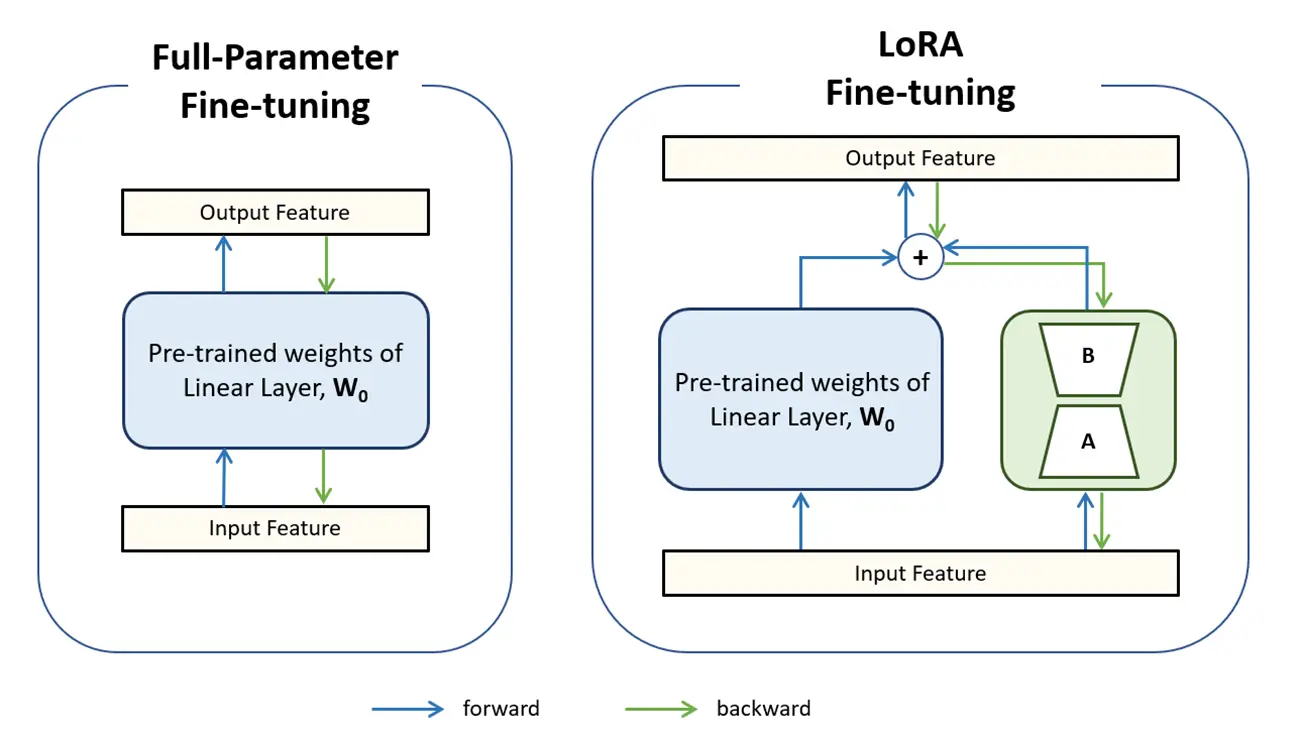

In [5]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=10,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q","v"],
    bias='none',
)
model = get_peft_model(model, lora_config)
print_trainable_parameters(model)

trainable params: 1105920 || all params: 248683776 || trainable%: 0.44


In [6]:
dataset = datasets.load_dataset("json", data_files=["./dataset.json"], split="train")

def clean(example):
    example["context"] = example["context"].split("http")[0]
    return example
dataset = dataset.map(clean)
dataset = dataset.train_test_split(0.1, shuffle=True, seed = 42)

dataset

DatasetDict({
    train: Dataset({
        features: ['context', 'target'],
        num_rows: 8588
    })
    test: Dataset({
        features: ['context', 'target'],
        num_rows: 955
    })
})

In [7]:
def data_collator(batch):
    model_inputs = tokenizer(
        [ex["context"] for ex in batch],
        padding="longest",
        truncation=True,
        return_tensors="pt"
    )

    labels = tokenizer(
        [ex["target"] for ex in batch],
        padding="longest",
        truncation=True,
        return_tensors="pt"
    )["input_ids"]

    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels

    return model_inputs

In [ ]:
training_args = TrainingArguments(
        output_dir='./saved_models/training_log',
        logging_steps = 10,
        num_train_epochs = 3,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,
        learning_rate=1e-4,
        warmup_steps=200,
        weight_decay=0.01,
        # fp16=True,
        torch_compile = False,
        remove_unused_columns=False,
    )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
)

trainer.train()

In [16]:
model.save_pretrained("./saved_models/finetuned_model")

# Assessing the performance before and after fine tuning

In [18]:
model_size = "base"

base_model = T5ForConditionalGeneration.from_pretrained("./saved_models/" + model_size)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-" + model_size)

In [19]:
X = list(dataset["test"]['context'])
Y = list(dataset["test"]['target'])

In [20]:
tokenizer.decode(base_model.generate(input_ids=tokenizer(X[10], return_tensors="pt")["input_ids"], attention_mask=tokenizer(X[10], return_tensors="pt")["attention_mask"])[0], skip_special_tokens=True)

'negative'

In [21]:
import copy
peft_model = PeftModel.from_pretrained(copy.deepcopy(base_model), "./saved_models/fully_finetuned")
tokenizer.decode(peft_model.generate(input_ids=tokenizer(X[10], return_tensors="pt")["input_ids"], attention_mask=tokenizer(X[10], return_tensors="pt")["attention_mask"])[0], skip_special_tokens=True)

'neutral'

In [ ]:
import copy, time

x0 = 0
n = len(X)

def pred_base(example):
    res =tokenizer(example, return_tensors="pt")
    res = base_model.generate(input_ids=res["input_ids"], attention_mask=res["attention_mask"])
    res = tokenizer.decode(res[0], skip_special_tokens=True)
    return res

t0 = time.time()
Ypred_base = [pred_base(x) for x in X[x0:x0+n]]
base_accuracy = sum([Ypred_base[i] == Y[x0+i] for i in range(n)]) / n * 100
t1 = time.time()
print(f"Base Inference: {(t1-t0)/n:.3f} sec/sample")
print(f"Base Accuracy: {base_accuracy:.0f}%")



def pred_peft(example):
    res =tokenizer(example, return_tensors="pt")
    res = peft_model.generate(input_ids=res["input_ids"], attention_mask=res["attention_mask"], max_new_tokens=5)
    res = tokenizer.decode(res[0], skip_special_tokens=True)
    return res

t0 = time.time()
Ypred_peft      = [pred_peft(x) for x in X[x0:x0+n]]
peft_accuracy   = sum([Ypred_peft[i] == Y[x0+i] for i in range(n)]) / n * 100
t1 = time.time()
print(f"Peft Inference: {(t1-t0)/n:.3f} sec/sample")
print(f"Peft Accuracy: {peft_accuracy:.0f}%")

Base Inference: 0.161 sec/sample
Base Accuracy: 25%
Peft Inference: 0.171 sec/sample
Peft Accuracy: 83%


In [10]:
from sklearn.metrics import confusion_matrix
print(f"{(confusion_matrix(Y, Ypred_base, normalize='true').round(3) *100)}\n")
print(f"{(confusion_matrix(Y, Ypred_peft, normalize='true').round(3) *100)}")

[[99.3  0.   0.7]
 [70.3  0.  29.7]
 [45.7  0.  54.3]]

[[69.9 23.5  6.6]
 [ 4.8 89.1  6.1]
 [ 1.5 25.9 72.6]]


### with pipeline

In [24]:
from transformers import pipeline
import copy

peft_model = PeftModel.from_pretrained(copy.deepcopy(base_model), "./saved_models/finetuned_model")
peft_model = peft_model.merge_and_unload()
peft_model.save_pretrained("./saved_models/merged_model")

# load using pipeline
peft_model_ppln = pipeline("text2text-generation", model="./saved_models/merged_model", tokenizer="./saved_models/" + model_size)
peft_model_ppln("who is the current president of the US?")

Device set to use cpu


[{'generated_text': 'Mitt Romney'}]

In [ ]:
t0 = time.time()
Ypred_peft_ppln = peft_model_ppln(X[x0:x0+n], max_new_tokens=5)
Ypred_peft_ppln = [y["generated_text"] for y in Ypred_peft_ppln]
peft_accuracy_ppln = sum([Ypred_peft_ppln[i] == Y[x0+i] for i in range(n)]) / n
t1 = time.time()
print(f"Pipeline Inference (sam/sec) {(t1-t0)/n:.3f} ")
print(f"Peft Accuracy: {peft_accuracy_ppln:.0f}%")

Pipeline Inference (sam/sec) 0.215
Peft Accuracy: 83%


In [14]:
print(f"{(confusion_matrix(Y, Ypred_peft_ppln, normalize='true').round(3) *100)}")

[[69.9 23.5  6.6]
 [ 4.8 89.1  6.1]
 [ 1.5 25.9 72.6]]


In [22]:
peft_model = T5ForConditionalGeneration.from_pretrained("./saved_models/merged_model")
def pred_peft(example):
    res =tokenizer(example, return_tensors="pt")
    res = peft_model.generate(input_ids=res["input_ids"], attention_mask=res["attention_mask"], max_new_tokens=5)
    res = tokenizer.decode(res[0], skip_special_tokens=True)
    return res

t0 = time.time()
Ypred_peft      = [pred_peft(x) for x in X[x0:x0+n]]
peft_accuracy   = sum([Ypred_peft[i] == Y[x0+i] for i in range(n)]) / n * 100
t1 = time.time()
print(f"Peft Inference: {(t1-t0)/n:.3f} sec/sample")
print(f"Peft Accuracy: {peft_accuracy:.0f}%")

Peft Inference: 0.148 sec/sample
Peft Accuracy: 83%


In [23]:
print(f"{(confusion_matrix(Y, Ypred_peft, normalize='true').round(3) *100)}")

[[69.9 23.5  6.6]
 [ 4.8 89.1  6.1]
 [ 1.5 25.9 72.6]]


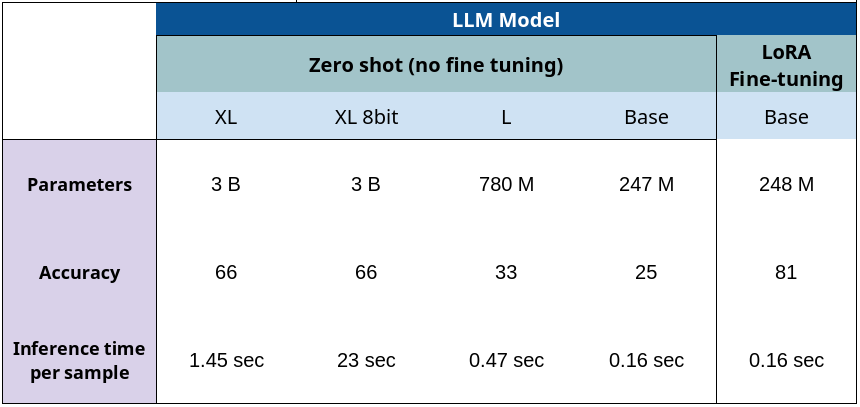